## Задание на кластеризацию. Срок: 5 декабря.

In [1]:
import numpy as np
import pandas as pd
import random
import math
import sklearn.datasets as ds 
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
# Загрузите данные по покимонам

X = pd.read_csv("data/Pokemon.csv", index_col=0)
X.shape

(800, 12)

In [3]:
y = list(X['Legendary'].map({True: 1, False:0}))
X = X._get_numeric_data().dropna(axis=1).drop('Legendary', axis=1)

In [4]:
# Спойлер: попробуйте решить задачу со скейлингом и без

ms = MinMaxScaler()
ms.fit(X)
X = ms.transform(X)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [5]:
# С помощью TSNE отобразим данные на плоскости 
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17, verbose=2, n_iter=10000, n_iter_without_progress=1000)

res = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.002s...
[t-SNE] Computed neighbors for 800 samples in 0.336s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 0.149002
[t-SNE] Computed conditional probabilities in 0.030s
[t-SNE] Iteration 50: error = 64.7367249, gradient norm = 0.3759606 (50 iterations in 0.681s)
[t-SNE] Iteration 100: error = 64.4262543, gradient norm = 0.3652945 (50 iterations in 0.574s)
[t-SNE] Iteration 150: error = 63.9621849, gradient norm = 0.3675893 (50 iterations in 0.487s)
[t-SNE] Iteration 200: error = 64.6097107, gradient norm = 0.3703400 (50 iterations in 0.454s)
[t-SNE] Iteration 250: error = 64.6265717, gradient norm = 0.3703052 (50 iterations in 0.371s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.626572
[t-SNE] Iteration 300: error = 0.8995736, gradient norm = 0.0013812 (50 iterations in 0.288s)
[t-SNE] Iteration 350: error = 0.8384154, gradient norm = 0.0002755 (

[t-SNE] Iteration 4200: error = 0.8123529, gradient norm = 0.0000425 (50 iterations in 0.278s)
[t-SNE] Iteration 4250: error = 0.8123975, gradient norm = 0.0000356 (50 iterations in 0.252s)
[t-SNE] Iteration 4300: error = 0.8124084, gradient norm = 0.0000380 (50 iterations in 0.274s)
[t-SNE] Iteration 4350: error = 0.8124229, gradient norm = 0.0000413 (50 iterations in 0.244s)
[t-SNE] Iteration 4400: error = 0.8123426, gradient norm = 0.0000398 (50 iterations in 0.333s)
[t-SNE] Iteration 4450: error = 0.8123810, gradient norm = 0.0000525 (50 iterations in 0.311s)
[t-SNE] Iteration 4500: error = 0.8124155, gradient norm = 0.0000387 (50 iterations in 0.263s)
[t-SNE] Iteration 4500: did not make any progress during the last 1000 episodes. Finished.
[t-SNE] KL divergence after 4500 iterations: 0.812415


Text(0.5, 1.0, 'TSNE')

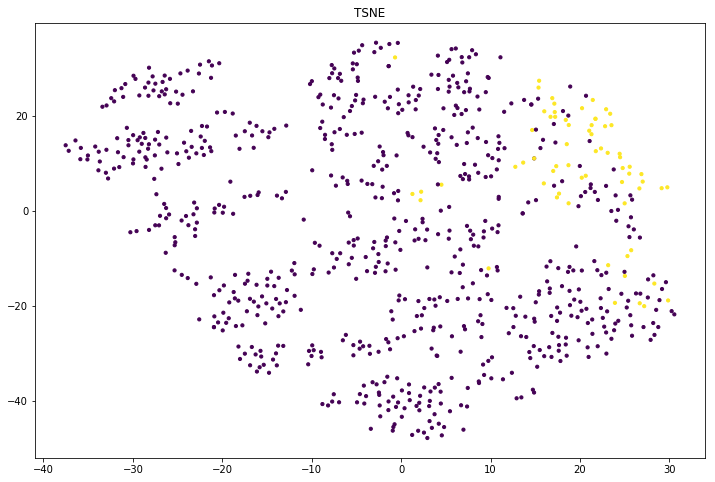

In [6]:
# Посмотрим на реальное расположение классов

plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=y, s=10)
plt.title('TSNE')

Видно, что классы сгруппировались в одном месте. Но там не только они. Интересно, наши алгоритмы смогут что-то сделать?

### Kmeans

In [7]:
Ks = range(1, 15)
score = [KMeans(n_clusters=i, n_jobs=-1).fit(X).inertia_ for i in Ks]

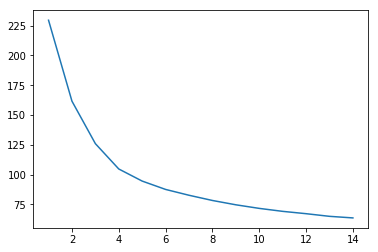

In [8]:
plt.plot(Ks, score)

Text(0.5, 1.0, 'TSNE')

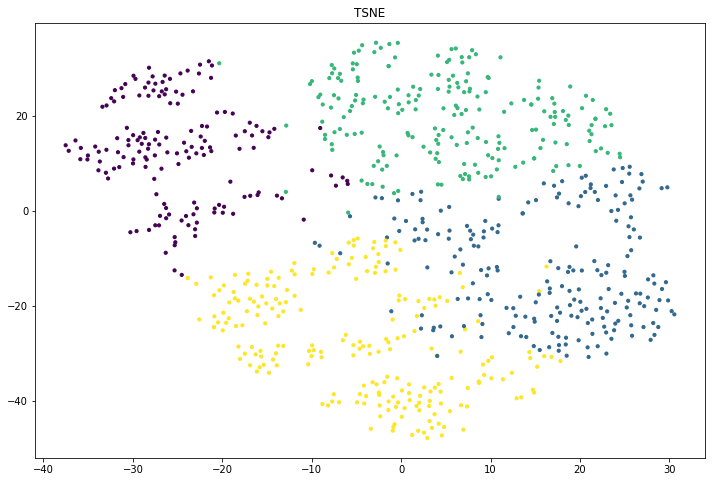

In [9]:
# Можно попробовать 3 или 4 кластера

kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X)

plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=kmeans.labels_, s=10, cmap='viridis')
plt.title('TSNE')

Как и казалось очевидным, kmean побил на 3 видимых класса. И да, он поместил все семплы с таргетом 1 в один класс. На самом деле, это может быть полезным.

#### Метрики

Помимо метрики Silhouette, которую мы рассматривали на семинаре, есть метрики, которые считают качество кластеризации на данных, где есть разметка. Вместо данных они на вход получают кластеры и реальную разметку.

Ниже перечислены некоторые из этих метрик. Как думаете, какая самая уместная в нашей задаче?

from sklearn import metrics

        'AMI': metrics.adjusted_mutual_info_score(y, preds),
        'ARI': metrics.adjusted_rand_score(y, preds),
        'V-measure': metrics.v_measure_score(y, preds),
        'Homogenity': metrics.homogeneity_score(y, preds),
        'Completeness': metrics.completeness_score(y, preds)

### DBSCAN

Посмотрим, как DBSCAN справится с задачей кластеризации. Переберем разные значения параметров алгоритма и сравним качество по метрикам.

Максимизация какой метрики, на ваш взгляд, дает лучшее разбиение?

In [14]:
from sklearn.cluster import DBSCAN
import numpy as np

0.09517692309028979


Text(0.5, 1.0, 'TSNE - AMI')

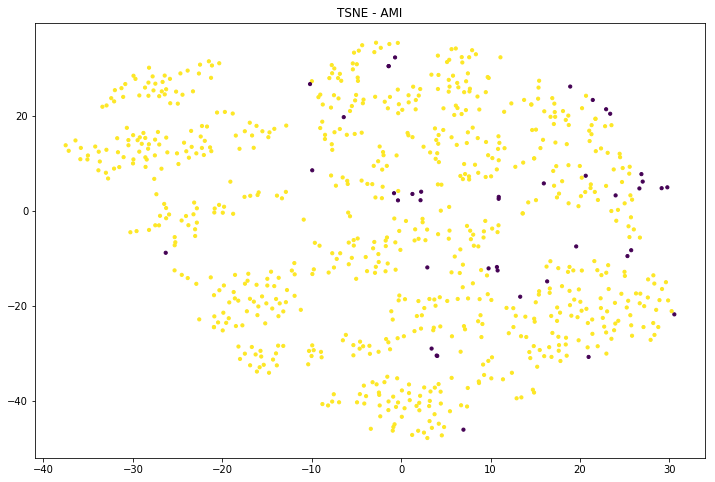

In [16]:
#adjusted_mutual_info_score

eps = np.arange(0.3, 1, 0.1) #np.linspace(30, 130, 101)
# Если будете скалировать, то вам нужно будет взять eps < 1. Почему?
samples = range(3, 10)

scores = []
best_sc = -1
best_ep = None
best_sa = None
for ep in eps:
    for sa in samples:
        clst = DBSCAN(eps=ep, min_samples=sa)
        pred = clst.fit_predict(X)
        try:
            sc = metrics.adjusted_mutual_info_score(y, pred, average_method='geometric')
            if sc > best_sc:
                best_sc = sc
                best_ep = ep
                best_sa = sa
            scores.append((ep, sa, sc))
        except Exception as e:
            print(e)
            pass
     
clst = DBSCAN(eps=best_ep, min_samples=best_sa)
pred = clst.fit_predict(X)
print(metrics.adjusted_mutual_info_score(y, pred, average_method='geometric'))

plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=pred, s=10, cmap='viridis')
plt.title('TSNE - AMI')

0.24679300343749355


Text(0.5, 1.0, 'TSNE - ARI')

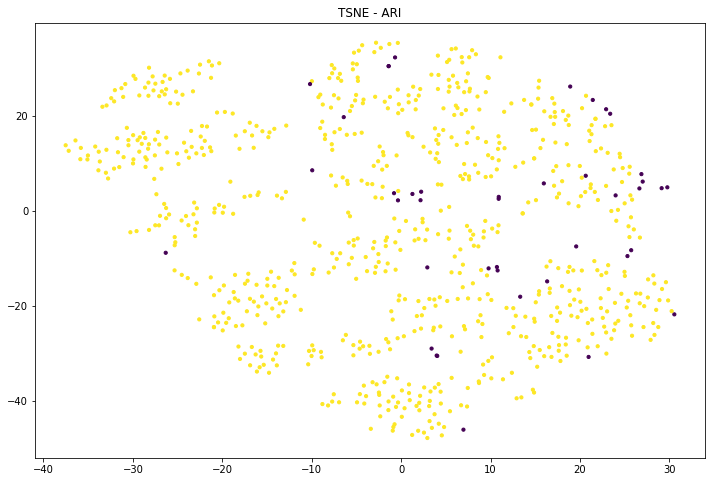

In [17]:
#adjusted_rand_score

eps = np.arange(0.3, 1, 0.1) #np.linspace(30, 130, 101)
# Если будете скалировать, то вам нужно будет взять eps < 1. Почему?
samples = range(3, 10)

scores = []
best_sc = -1
best_ep = None
best_sa = None
for ep in eps:
    for sa in samples:
        clst = DBSCAN(eps=ep, min_samples=sa)
        pred = clst.fit_predict(X)
        try:
            sc = metrics.adjusted_rand_score(y, pred)
            if sc > best_sc:
                best_sc = sc
                best_ep = ep
                best_sa = sa
            scores.append((ep, sa, sc))
        except:
            pass

clst = DBSCAN(eps=best_ep, min_samples=best_sa)
pred = clst.fit_predict(X)
print(metrics.adjusted_rand_score(y, pred))

plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=pred, s=10, cmap='viridis')
plt.title('TSNE - ARI')

Повторите такую процедуру с остальными метриками и выберите, максимизация какой метрики, дает лучшее разбиение.

#### Еще кластеризация
Посмотрите на короткую справку по [типовым методам кластеризации](https://scikit-learn.org/stable/modules/clustering.html).

Реализуйте еще какой-нибудь алгоритм, который вам нравится, и проведите то же исследование, что было с DBSCAN.

Какой алгоритм и максимизация какой метрики дали наилучший визуальный результат? Почему?


0.24679300343749355


Text(0.5, 1.0, 'TSNE - V-measure')

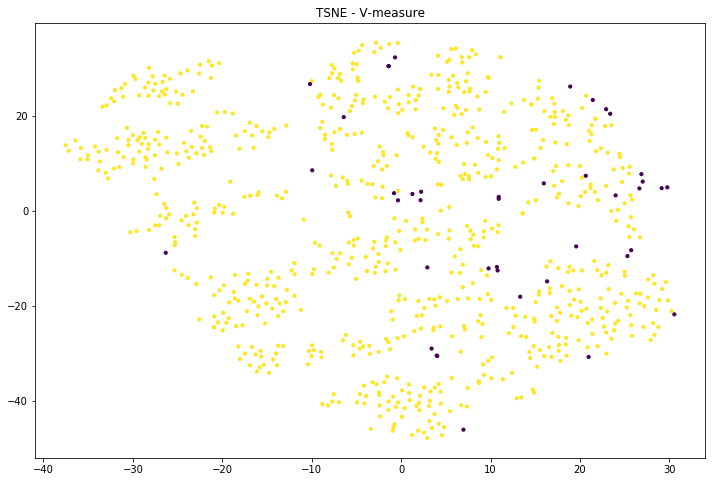

In [18]:
#v_measure_score

eps = np.arange(0.3, 1, 0.1) #np.linspace(30, 130, 101)
# Если будете скалировать, то вам нужно будет взять eps < 1. Почему?
samples = range(3, 10)

scores = []
best_sc = -1
best_ep = None
best_sa = None
for ep in eps:
    for sa in samples:
        clst = DBSCAN(eps=ep, min_samples=sa)
        pred = clst.fit_predict(X)
        try:
            sc = metrics.v_measure_score(y, pred)
            if sc > best_sc:
                best_sc = sc
                best_ep = ep
                best_sa = sa
            scores.append((ep, sa, sc))
        except:
            pass

clst = DBSCAN(eps=best_ep, min_samples=best_sa)
pred = clst.fit_predict(X)
print(metrics.adjusted_rand_score(y, pred))

plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=pred, s=10, cmap='viridis')
plt.title('TSNE - V-measure')

0.24679300343749355


Text(0.5, 1.0, 'TSNE - Homogenity')

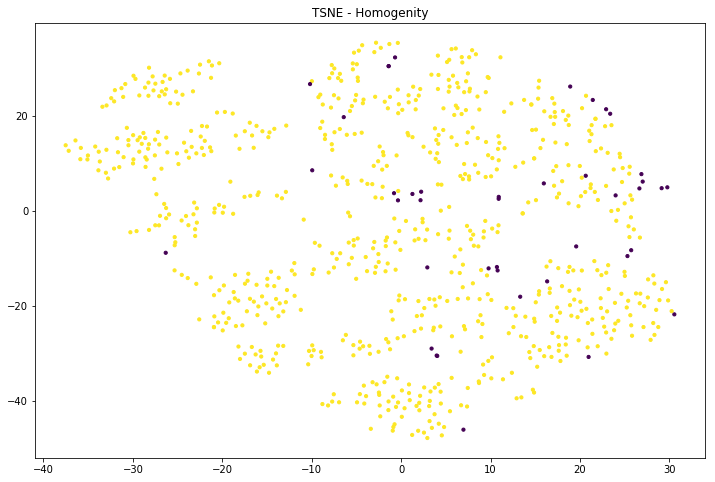

In [19]:
#Homogenity

eps = np.arange(0.3, 1, 0.1) #np.linspace(30, 130, 101)
# Если будете скалировать, то вам нужно будет взять eps < 1. Почему?
samples = range(3, 10)

scores = []
best_sc = -1
best_ep = None
best_sa = None
for ep in eps:
    for sa in samples:
        clst = DBSCAN(eps=ep, min_samples=sa)
        pred = clst.fit_predict(X)
        try:
            sc = metrics.homogeneity_score(y, pred)
            if sc > best_sc:
                best_sc = sc
                best_ep = ep
                best_sa = sa
            scores.append((ep, sa, sc))
        except:
            pass

clst = DBSCAN(eps=best_ep, min_samples=best_sa)
pred = clst.fit_predict(X)
print(metrics.adjusted_rand_score(y, pred))

plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=pred, s=10, cmap='viridis')
plt.title('TSNE - Homogenity')

0.0


Text(0.5, 1.0, 'TSNE - Completeness')

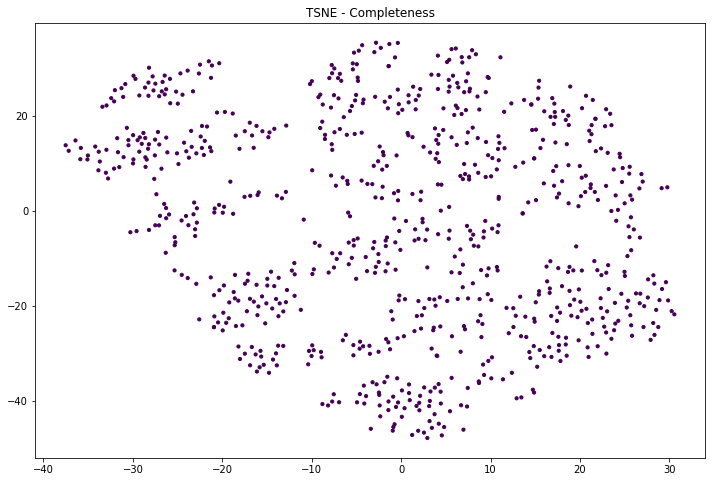

In [20]:
#Completeness

eps = np.arange(0.3, 1, 0.1) #np.linspace(30, 130, 101)
# Если будете скалировать, то вам нужно будет взять eps < 1. Почему?
samples = range(3, 10)

scores = []
best_sc = -1
best_ep = None
best_sa = None
for ep in eps:
    for sa in samples:
        clst = DBSCAN(eps=ep, min_samples=sa)
        pred = clst.fit_predict(X)
        try:
            sc = metrics.completeness_score(y, pred)
            if sc > best_sc:
                best_sc = sc
                best_ep = ep
                best_sa = sa
            scores.append((ep, sa, sc))
        except:
            pass

clst = DBSCAN(eps=best_ep, min_samples=best_sa)
pred = clst.fit_predict(X)
print(metrics.adjusted_rand_score(y, pred))

plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=pred, s=10, cmap='viridis')
plt.title('TSNE - Completeness')

# MeanShift
Реализуйте еще какой-нибудь алгоритм, который вам нравится, 
и проведите то же исследование, что было с DBSCAN.

In [21]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# The following bandwidth can be automatically detected using
_bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
_bandwidth

0.4952027345910742

0.0


Text(0.5, 1.0, 'TSNE - MeanShift - AMI')

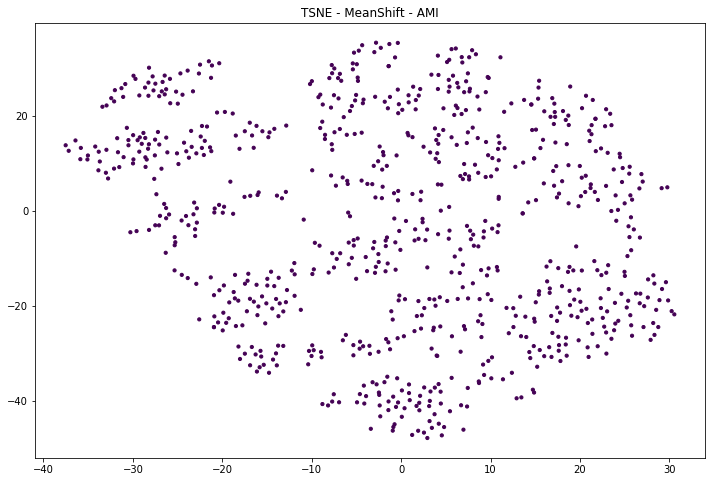

In [25]:
best_bandwidth = _bandwidth
bandwidth_list = np.arange(best_bandwidth-0.4, best_bandwidth+0.5, 0.1)

clst = MeanShift(bandwidth=best_bandwidth, bin_seeding=True)
pred = clst.fit_predict(X)    
best_sc = metrics.adjusted_mutual_info_score(y, pred, average_method='geometric')

for bandwidth in bandwidth_list:
    clst = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    pred = clst.fit_predict(X)
    try:
        sc = metrics.adjusted_mutual_info_score(y, pred, average_method='geometric')
        if sc > best_sc:
            best_bandwidth = bandwidth
    except:
        pass
    
clst = MeanShift(bandwidth=best_bandwidth, bin_seeding=True)
pred = clst.fit_predict(X)    
print(metrics.adjusted_mutual_info_score(y, pred, average_method='geometric'))

plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=pred, s=10, cmap='viridis')
plt.title('TSNE - MeanShift - AMI')

0.0


Text(0.5, 1.0, 'TSNE - MeanShift - ARI')

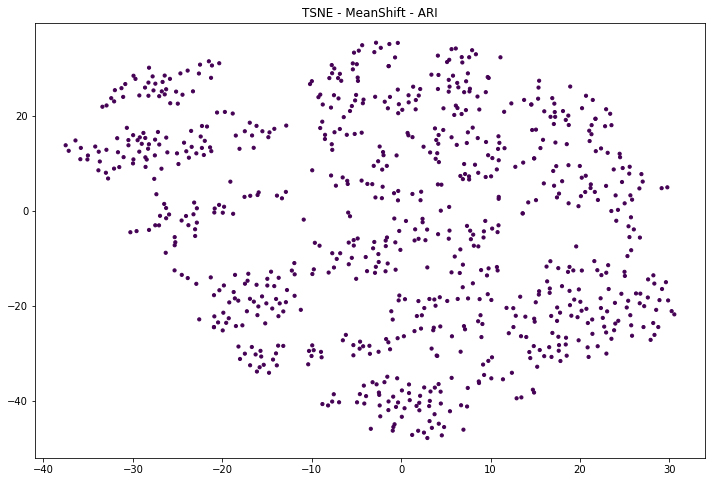

In [26]:
best_bandwidth = _bandwidth
bandwidth_list = np.arange(best_bandwidth-0.4, best_bandwidth+0.5, 0.1)

clst = MeanShift(bandwidth=best_bandwidth, bin_seeding=True)
pred = clst.fit_predict(X)    
best_sc = metrics.adjusted_rand_score(y, pred)

for bandwidth in bandwidth_list:
    clst = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    pred = clst.fit_predict(X)
    try:
        sc = metrics.adjusted_rand_score(y, pred)
        if sc > best_sc:
            best_bandwidth = bandwidth
    except:
        pass
    
clst = MeanShift(bandwidth=best_bandwidth, bin_seeding=True)
pred = clst.fit_predict(X)
print(metrics.adjusted_rand_score(y, pred))

plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=pred, s=10, cmap='viridis')
plt.title('TSNE - MeanShift - ARI')

0.039433701901049514


Text(0.5, 1.0, 'TSNE - MeanShift - V-measure')

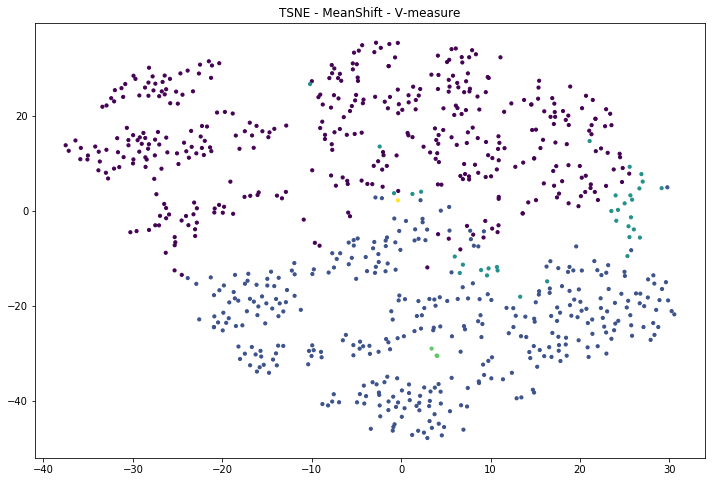

In [28]:
best_bandwidth = _bandwidth
bandwidth_list = np.arange(best_bandwidth-0.4, best_bandwidth+0.5, 0.1)

clst = MeanShift(bandwidth=best_bandwidth, bin_seeding=True)
pred = clst.fit_predict(X)    
best_sc = metrics.v_measure_score(y, pred)

for bandwidth in bandwidth_list:
    clst = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    pred = clst.fit_predict(X)
    try:
        sc = metrics.v_measure_score(y, pred)
        if sc > best_sc:
            best_bandwidth = bandwidth
    except:
        pass
    
clst = MeanShift(bandwidth=best_bandwidth, bin_seeding=True)
pred = clst.fit_predict(X)
print(metrics.v_measure_score(y, pred))

plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=pred, s=10, cmap='viridis')
plt.title('TSNE - MeanShift - V-measure')

0.08048226918718601


Text(0.5, 1.0, 'TSNE - MeanShift - Homogenity')

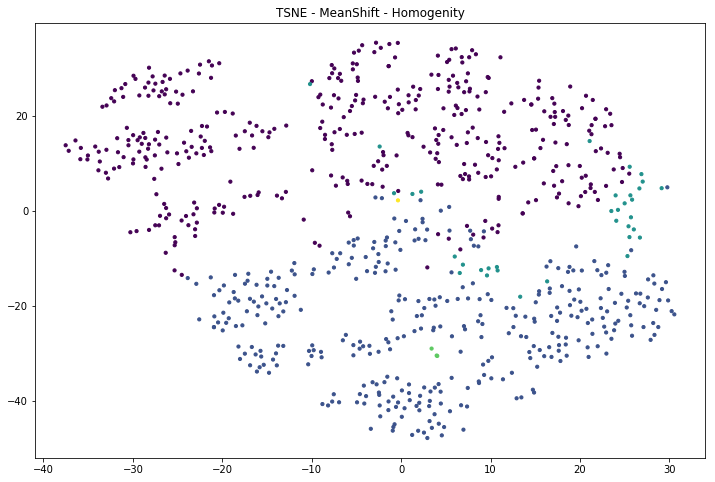

In [29]:
best_bandwidth = _bandwidth
bandwidth_list = np.arange(best_bandwidth-0.4, best_bandwidth+0.5, 0.1)

clst = MeanShift(bandwidth=best_bandwidth, bin_seeding=True)
pred = clst.fit_predict(X)    
best_sc = metrics.homogeneity_score(y, pred)

for bandwidth in bandwidth_list:
    clst = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    pred = clst.fit_predict(X)
    try:
        sc = metrics.homogeneity_score(y, pred)
        if sc > best_sc:
            best_bandwidth = bandwidth
    except:
        pass
    
clst = MeanShift(bandwidth=best_bandwidth, bin_seeding=True)
pred = clst.fit_predict(X)
print(metrics.homogeneity_score(y, pred))

plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=pred, s=10, cmap='viridis')
plt.title('TSNE - MeanShift - Homogenity')

0.026114473524126398


Text(0.5, 1.0, 'TSNE - MeanShift - Completeness')

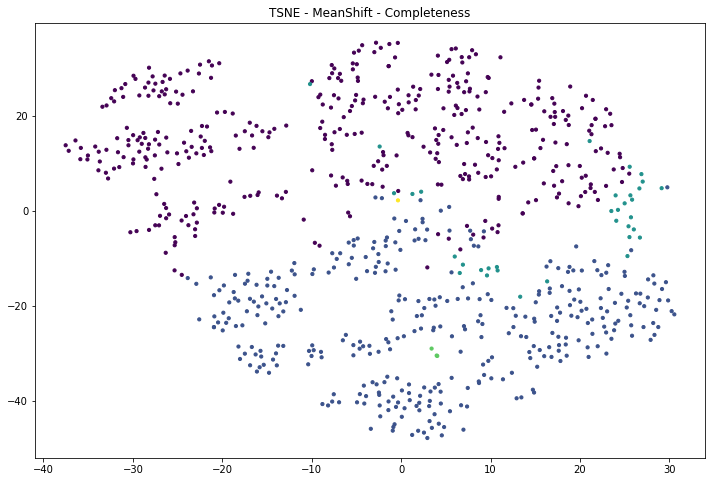

In [30]:
best_bandwidth = _bandwidth
bandwidth_list = np.arange(best_bandwidth-0.4, best_bandwidth+0.5, 0.1)

clst = MeanShift(bandwidth=best_bandwidth, bin_seeding=True)
pred = clst.fit_predict(X)    
best_sc = metrics.homogeneity_score(y, pred)

for bandwidth in bandwidth_list:
    clst = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    pred = clst.fit_predict(X)
    try:
        sc = metrics.homogeneity_score(y, pred)
        if sc > best_sc:
            best_bandwidth = bandwidth
    except:
        pass
    
clst = MeanShift(bandwidth=best_bandwidth, bin_seeding=True)
pred = clst.fit_predict(X)
print(metrics.completeness_score(y, pred))

plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=pred, s=10, cmap='viridis')
plt.title('TSNE - MeanShift - Completeness')